# PCA

- Fabian Oppermann
- Petruta-Denisa Biholari
- Philipp Hasel

https://www.kaggle.com/datasets/nelgiriyewithana/most-streamed-spotify-songs-2024

In [1]:
%pip install pandas matplotlib scikit-learn sea

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

df = pd.read_csv("./Most Streamed Spotify Songs 2024.csv", encoding="latin1")

# 1. Datenbereinigung

In [3]:
df = df.drop_duplicates()

# Fehlende Werte analysieren
missing = df.isnull().sum()
print("Fehlende Werte pro Spalte vor weiterer Bereinigung:")
print(missing[missing > 0])

df = df.dropna(subset=['Spotify Streams', 'TikTok Posts', 'Spotify Popularity'])

df = df.drop(columns=["TIDAL Popularity"])

df = df.drop(columns=['Track', 'Album Name', 'ISRC'])

# Datei speichern
df.to_csv("korr.csv", index=False)

Fehlende Werte pro Spalte vor weiterer Bereinigung:
Artist                           5
Spotify Streams                113
Spotify Playlist Count          70
Spotify Playlist Reach          72
Spotify Popularity             804
YouTube Views                  308
YouTube Likes                  315
TikTok Posts                  1173
TikTok Likes                   980
TikTok Views                   981
YouTube Playlist Reach        1009
Apple Music Playlist Count     561
AirPlay Spins                  498
SiriusXM Spins                2123
Deezer Playlist Count          921
Deezer Playlist Reach          928
Amazon Playlist Count         1055
Pandora Streams               1106
Pandora Track Stations        1268
Soundcloud Streams            3332
Shazam Counts                  577
TIDAL Popularity              4598
dtype: int64


# 2. kNN und PCA

In [4]:

# Numerische Spalten identifizieren, die als Objekt-Typ geladen wurden und Kommas enthalten könnten
for col in df.columns:
    if df[col].dtype == object:
        # Versuch, Kommas zu entfernen und in numerischen Typ umzuwandeln
        # Behält Spalten, die nicht numerisch sind (z.B. 'Artist', 'Release Date'), als Objekt
        try:
            # Teste, ob nach dem Ersetzen von Kommas eine Umwandlung in float möglich ist
            pd.to_numeric(df[col].str.replace(',', '', regex=False))
            df[col] = df[col].str.replace(',', '', regex=False).astype(float)
            print(f"Spalte '{col}' wurde zu float konvertiert.")
        except ValueError:
            # Wenn die Umwandlung fehlschlägt, ist es wahrscheinlich eine echte Zeichenkette
            print(f"Spalte '{col}' konnte nicht zu float konvertiert werden und bleibt Objekt.")
        except AttributeError: # Falls .str nicht verfügbar ist (z.B. wenn es bereits numerisch ist, aber als Objekt)
             try:
                df[col] = pd.to_numeric(df[col])
                print(f"Spalte '{col}' (ursprünglich Objekt) wurde zu numerisch konvertiert.")
             except ValueError:
                print(f"Spalte '{col}' (ursprünglich Objekt) konnte nicht zu numerisch konvertiert werden.")


# Zielvariable PopularityClass erstellen mit pd.cut (konsistent)
# Die Bins sollten die gesamte mögliche Range von Spotify Popularity abdecken (typischerweise 0-100)
df['PopularityClass'] = pd.cut(df['Spotify Popularity'], 
                                bins=[-1, 40, 70, 101], # Anpassung der oberen Grenze auf 101 (oder df['Spotify Popularity'].max() + 1)
                                labels=['Low', 'Medium', 'High'], 
                                right=True) # right=True bedeutet, dass der rechte Bin-Rand inklusive ist


if df['PopularityClass'].isnull().any():
    print("Warnung: Es gibt NaN-Werte in 'PopularityClass' nach pd.cut. Überprüfen Sie die Bins und Werte in 'Spotify Popularity'.")
    print(df[df['PopularityClass'].isnull()]['Spotify Popularity'])
    # Optionale Behandlung: df.dropna(subset=['PopularityClass'], inplace=True)

Spalte 'Artist' konnte nicht zu float konvertiert werden und bleibt Objekt.
Spalte 'Release Date' konnte nicht zu float konvertiert werden und bleibt Objekt.
Spalte 'All Time Rank' wurde zu float konvertiert.
Spalte 'Spotify Streams' wurde zu float konvertiert.
Spalte 'Spotify Playlist Count' wurde zu float konvertiert.
Spalte 'Spotify Playlist Reach' wurde zu float konvertiert.
Spalte 'YouTube Views' wurde zu float konvertiert.
Spalte 'YouTube Likes' wurde zu float konvertiert.
Spalte 'TikTok Posts' wurde zu float konvertiert.
Spalte 'TikTok Likes' wurde zu float konvertiert.
Spalte 'TikTok Views' wurde zu float konvertiert.
Spalte 'YouTube Playlist Reach' wurde zu float konvertiert.
Spalte 'AirPlay Spins' wurde zu float konvertiert.
Spalte 'SiriusXM Spins' wurde zu float konvertiert.
Spalte 'Deezer Playlist Reach' wurde zu float konvertiert.
Spalte 'Pandora Streams' wurde zu float konvertiert.
Spalte 'Pandora Track Stations' wurde zu float konvertiert.
Spalte 'Soundcloud Streams' wur

In [5]:
import numpy as np
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


non_features = ['Artist', 'Release Date', 'Explicit Track', 'Spotify Popularity', 'PopularityClass']
X = df.drop(columns=non_features, errors='ignore') # errors='ignore' falls eine Spalte schon fehlt
y = df['PopularityClass'].dropna() # Sicherstellen, dass y keine NaNs hat, falls welche durch pd.cut entstanden
X = X.loc[y.index] # X und y synchron halten

# Kategoriale und numerische Features für den Preprocessor identifizieren
num_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(include=['object', 'bool']).columns # Bool hier auch als cat behandelt für OneHotEncoding

# Labels in Zahlen umwandeln für y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Daten splitten
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Preprocessing Pipelines
# Numerische Pipeline: Fehlende Werte mit Median füllen (robuster gegen Ausreißer als Mittelwert) & skalieren
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")), # Geändert zu Median für Konsistenz und Robustheit
    ("scaler", StandardScaler())
])

# Kategoriale Pipeline: Fehlende Werte mit häufigstem Wert füllen & OneHot kodieren
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer, um Pipelines auf die richtigen Spalten anzuwenden
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Besten Modelle laut Grid-Search:
"""
--- Random Forest ---
Beste Parameter: {'classifier__max_depth': None, 'classifier__n_estimators': 50}
Laufzeit: 1.64 Sekunden
Bestes CV-Score (Accuracy): 0.8155

--- KNN ---
Beste Parameter: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Laufzeit: 0.13 Sekunden
Bestes CV-Score (Accuracy): 0.7704
"""

"\n--- Random Forest ---\nBeste Parameter: {'classifier__max_depth': None, 'classifier__n_estimators': 50}\nLaufzeit: 1.64 Sekunden\nBestes CV-Score (Accuracy): 0.8155\n\n--- KNN ---\nBeste Parameter: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}\nLaufzeit: 0.13 Sekunden\nBestes CV-Score (Accuracy): 0.7704\n"

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import time


random_forest_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=50, max_depth=None, random_state=42))
])

knn_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=7, weights='distance'))
])

# Modelle trainieren
start_train_rf = time.time()
random_forest_pipeline.fit(X_train, y_train)
train_time_rf = time.time() - start_train_rf

start_train_knn = time.time()
knn_pipeline.fit(X_train, y_train)
train_time_knn = time.time() - start_train_knn

# Modelle evaluieren
from sklearn.metrics import classification_report, confusion_matrix
models = {
    "Random Forest": random_forest_pipeline,
    "kNN": knn_pipeline
}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    start_pred = time.time()
    y_pred = model.predict(X_val)
    pred_time = time.time() - start_pred
    print(classification_report(y_val, y_pred, target_names=le.classes_))
    print(f"Trainingszeit: {train_time_rf if model_name == 'Random Forest' else train_time_knn:.4f} Sekunden")
    print(f"Vorhersagezeit: {pred_time:.4f} Sekunden")

Evaluating Random Forest...
              precision    recall  f1-score   support

        High       0.79      0.72      0.75       209
         Low       0.84      0.46      0.59        35
      Medium       0.82      0.90      0.86       394

    accuracy                           0.81       638
   macro avg       0.82      0.69      0.73       638
weighted avg       0.81      0.81      0.81       638

Trainingszeit: 0.6378 Sekunden
Vorhersagezeit: 0.0120 Sekunden
Evaluating kNN...
              precision    recall  f1-score   support

        High       0.75      0.65      0.69       209
         Low       0.41      0.20      0.27        35
      Medium       0.78      0.87      0.82       394

    accuracy                           0.76       638
   macro avg       0.64      0.57      0.59       638
weighted avg       0.75      0.76      0.75       638

Trainingszeit: 0.0150 Sekunden
Vorhersagezeit: 0.3527 Sekunden


# 3. PCA Analyse mit 95% Varianzabdeckung

PCA (Principal Component Analysis) mit 95% Varianzabdeckung an und vergleichen:
- Performance (Trainings- und Vorhersagezeit)
- Modellqualität (Accuracy, Precision, Recall, F1-Score)
- Visualisierung der erklärten Varianz

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Zuerst die Daten vorverarbeiten (ohne PCA)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

print(f"Original Anzahl der Features: {X_train_preprocessed.shape[1]}")

# PCA mit 95% Varianzabdeckung
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_preprocessed)
X_val_pca = pca.transform(X_val_preprocessed)

print(f"Tatsächlich erklärte Varianz: {pca.explained_variance_ratio_.sum():.4f}")
print(f"Reduktion: {X_train_preprocessed.shape[1]} => {X_train_pca.shape[1]} Features")

Original Anzahl der Features: 21
Tatsächlich erklärte Varianz: 0.9600
Reduktion: 21 => 15 Features


## 3.1 Random Forest - Vergleich OHNE und MIT PCA

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

print("="*80)
print("Random Forest - Ohne PCA")
print("="*80)

# Training ohne PCA
rf_without_pca = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=42)

start_train = time.time()
rf_without_pca.fit(X_train_preprocessed, y_train)
train_time_no_pca = time.time() - start_train

# Vorhersage ohne PCA
start_pred = time.time()
y_pred_no_pca = rf_without_pca.predict(X_val_preprocessed)
pred_time_no_pca = time.time() - start_pred

# Metriken berechnen
acc_no_pca = accuracy_score(y_val, y_pred_no_pca)
prec_no_pca = precision_score(y_val, y_pred_no_pca, average='weighted')
rec_no_pca = recall_score(y_val, y_pred_no_pca, average='weighted')
f1_no_pca = f1_score(y_val, y_pred_no_pca, average='weighted')

print(f"Trainingszeit: {train_time_no_pca:.4f} Sekunden")
print(f"Vorhersagezeit: {pred_time_no_pca:.4f} Sekunden")
print(f"Accuracy: {acc_no_pca:.4f}")
print(f"Precision (weighted): {prec_no_pca:.4f}")
print(f"Recall (weighted): {rec_no_pca:.4f}")
print(f"F1-Score (weighted): {f1_no_pca:.4f}")
print(f"\nDetaillierter Report:")
print(classification_report(y_val, y_pred_no_pca, target_names=le.classes_))

print("\n" + "="*80)
print("Random Forest - Mit PCA (95% Varianz)")
print("="*80)

# Training mit PCA
rf_with_pca = RandomForestClassifier(n_estimators=50, max_depth=None, random_state=42)

start_train = time.time()
rf_with_pca.fit(X_train_pca, y_train)
train_time_pca = time.time() - start_train

# Vorhersage mit PCA
start_pred = time.time()
y_pred_pca = rf_with_pca.predict(X_val_pca)
pred_time_pca = time.time() - start_pred

# Metriken berechnen
acc_pca = accuracy_score(y_val, y_pred_pca)
prec_pca = precision_score(y_val, y_pred_pca, average='weighted')
rec_pca = recall_score(y_val, y_pred_pca, average='weighted')
f1_pca = f1_score(y_val, y_pred_pca, average='weighted')

print(f"Trainingszeit: {train_time_pca:.4f} Sekunden")
print(f"Vorhersagezeit: {pred_time_pca:.4f} Sekunden")
print(f"Accuracy: {acc_pca:.4f}")
print(f"Precision (weighted): {prec_pca:.4f}")
print(f"Recall (weighted): {rec_pca:.4f}")
print(f"F1-Score (weighted): {f1_pca:.4f}")
print(f"\nDetaillierter Report:")
print(classification_report(y_val, y_pred_pca, target_names=le.classes_))

print("\n" + "="*80)
print("Random Forest - Vergleich")
print("="*80)

print(f"Trainingszeit-Änderung: {((train_time_pca - train_time_no_pca) / train_time_no_pca * 100):.2f}%")
print(f"Vorhersagezeit-Änderung: {((pred_time_pca - pred_time_no_pca) / pred_time_no_pca * 100):.2f}%")
print(f"Accuracy-Änderung: {((acc_pca - acc_no_pca) / acc_no_pca * 100):.2f}%")
print(f"F1-Score-Änderung: {((f1_pca - f1_no_pca) / f1_no_pca * 100):.2f}%")

Random Forest - Ohne PCA
Trainingszeit: 0.5757 Sekunden
Vorhersagezeit: 0.0091 Sekunden
Accuracy: 0.8135
Precision (weighted): 0.8130
Recall (weighted): 0.8135
F1-Score (weighted): 0.8086

Detaillierter Report:
              precision    recall  f1-score   support

        High       0.79      0.72      0.75       209
         Low       0.84      0.46      0.59        35
      Medium       0.82      0.90      0.86       394

    accuracy                           0.81       638
   macro avg       0.82      0.69      0.73       638
weighted avg       0.81      0.81      0.81       638


Random Forest - Mit PCA (95% Varianz)
Trainingszeit: 0.5389 Sekunden
Vorhersagezeit: 0.0081 Sekunden
Accuracy: 0.7806
Precision (weighted): 0.7774
Recall (weighted): 0.7806
F1-Score (weighted): 0.7713

Detaillierter Report:
              precision    recall  f1-score   support

        High       0.73      0.72      0.72       209
         Low       0.73      0.23      0.35        35
      Medium       0

## 3.2 kNN - Vergleich OHNE und MIT PCA

In [9]:
print("="*80)
print("kNN - Ohne PCA")
print("="*80)

# Training ohne PCA
knn_without_pca = KNeighborsClassifier(n_neighbors=7, weights='distance')

start_train = time.time()
knn_without_pca.fit(X_train_preprocessed, y_train)
train_time_knn_no_pca = time.time() - start_train

# Vorhersage ohne PCA
start_pred = time.time()
y_pred_knn_no_pca = knn_without_pca.predict(X_val_preprocessed)
pred_time_knn_no_pca = time.time() - start_pred

# Metriken berechnen
acc_knn_no_pca = accuracy_score(y_val, y_pred_knn_no_pca)
prec_knn_no_pca = precision_score(y_val, y_pred_knn_no_pca, average='weighted')
rec_knn_no_pca = recall_score(y_val, y_pred_knn_no_pca, average='weighted')
f1_knn_no_pca = f1_score(y_val, y_pred_knn_no_pca, average='weighted')

print(f"Trainingszeit: {train_time_knn_no_pca:.4f} Sekunden")
print(f"Vorhersagezeit: {pred_time_knn_no_pca:.4f} Sekunden")
print(f"Accuracy: {acc_knn_no_pca:.4f}")
print(f"Precision (weighted): {prec_knn_no_pca:.4f}")
print(f"Recall (weighted): {rec_knn_no_pca:.4f}")
print(f"F1-Score (weighted): {f1_knn_no_pca:.4f}")
print(f"\nDetaillierter Report:")
print(classification_report(y_val, y_pred_knn_no_pca, target_names=le.classes_))

print("\n" + "="*80)
print("kNN - Mit PCA (95% Varianz)")
print("="*80)

# Training mit PCA
knn_with_pca = KNeighborsClassifier(n_neighbors=7, weights='distance')

start_train = time.time()
knn_with_pca.fit(X_train_pca, y_train)
train_time_knn_pca = time.time() - start_train

# Vorhersage mit PCA
start_pred = time.time()
y_pred_knn_pca = knn_with_pca.predict(X_val_pca)
pred_time_knn_pca = time.time() - start_pred

# Metriken berechnen
acc_knn_pca = accuracy_score(y_val, y_pred_knn_pca)
prec_knn_pca = precision_score(y_val, y_pred_knn_pca, average='weighted')
rec_knn_pca = recall_score(y_val, y_pred_knn_pca, average='weighted')
f1_knn_pca = f1_score(y_val, y_pred_knn_pca, average='weighted')

print(f"Trainingszeit: {train_time_knn_pca:.4f} Sekunden")
print(f"Vorhersagezeit: {pred_time_knn_pca:.4f} Sekunden")
print(f"Accuracy: {acc_knn_pca:.4f}")
print(f"Precision (weighted): {prec_knn_pca:.4f}")
print(f"Recall (weighted): {rec_knn_pca:.4f}")
print(f"F1-Score (weighted): {f1_knn_pca:.4f}")
print(f"\nDetaillierter Report:")
print(classification_report(y_val, y_pred_knn_pca, target_names=le.classes_))

print("\n" + "="*80)
print("kNN - Vergleich")
print("="*80)

print(f"Trainingszeit-Änderung: {((train_time_knn_pca - train_time_knn_no_pca) / train_time_knn_no_pca * 100):.2f}%")
print(f"Vorhersagezeit-Änderung: {((pred_time_knn_pca - pred_time_knn_no_pca) / pred_time_knn_no_pca * 100):.2f}%")
print(f"Accuracy-Änderung: {((acc_knn_pca - acc_knn_no_pca) / acc_knn_no_pca * 100):.2f}%")
print(f"F1-Score-Änderung: {((f1_knn_pca - f1_knn_no_pca) / f1_knn_no_pca * 100):.2f}%")

kNN - Ohne PCA
Trainingszeit: 0.0030 Sekunden
Vorhersagezeit: 0.0433 Sekunden
Accuracy: 0.7571
Precision (weighted): 0.7455
Recall (weighted): 0.7571
F1-Score (weighted): 0.7466

Detaillierter Report:
              precision    recall  f1-score   support

        High       0.75      0.65      0.69       209
         Low       0.41      0.20      0.27        35
      Medium       0.78      0.87      0.82       394

    accuracy                           0.76       638
   macro avg       0.64      0.57      0.59       638
weighted avg       0.75      0.76      0.75       638


kNN - Mit PCA (95% Varianz)
Trainingszeit: 0.0059 Sekunden
Vorhersagezeit: 0.0261 Sekunden
Accuracy: 0.7429
Precision (weighted): 0.7309
Recall (weighted): 0.7429
F1-Score (weighted): 0.7335

Detaillierter Report:
              precision    recall  f1-score   support

        High       0.71      0.65      0.68       209
         Low       0.41      0.20      0.27        35
      Medium       0.77      0.84      0

## 3.3 Visualisierung

Diese Visualisierung zeigt, wie viel Varianz durch die einzelnen Hauptkomponenten erklärt wird.

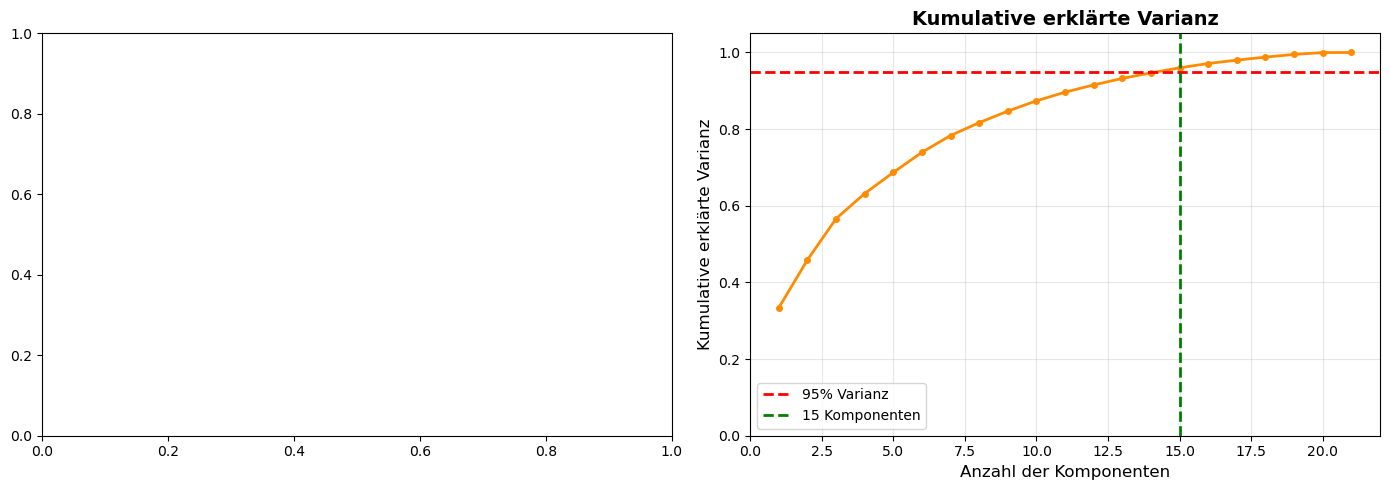


Für 95% Varianzabdeckung werden 15 von 21 Komponenten benötigt.
Das entspricht einer Reduktion auf 71.43% der ursprünglichen Dimensionen.


In [10]:
# PCA mit allen Komponenten für die Visualisierung
pca_full = PCA(random_state=42)
pca_full.fit(X_train_preprocessed)

# Kumulative erklärte Varianz berechnen
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Abbildung 8-8 nachzeichnen
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Rechtes Diagramm: Kumulative erklärte Varianz
ax[1].plot(range(1, len(cumulative_variance) + 1), 
           cumulative_variance, 
           'o-',
           linewidth=2, 
           markersize=4,
           color='darkorange')
ax[1].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% Varianz')
ax[1].axvline(x=pca.n_components_, color='green', linestyle='--', linewidth=2, 
              label=f'{pca.n_components_} Komponenten')
ax[1].set_xlabel('Anzahl der Komponenten', fontsize=12)
ax[1].set_ylabel('Kumulative erklärte Varianz', fontsize=12)
ax[1].set_title('Kumulative erklärte Varianz', fontsize=14, fontweight='bold')
ax[1].grid(True, alpha=0.3)
ax[1].legend(fontsize=10)
ax[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print(f"\nFür 95% Varianzabdeckung werden {pca.n_components_} von {len(pca_full.explained_variance_ratio_)} Komponenten benötigt.")
print(f"Das entspricht einer Reduktion auf {(pca.n_components_ / len(pca_full.explained_variance_ratio_) * 100):.2f}% der ursprünglichen Dimensionen.")

## 3.4 Zusammenfassende Analyse und Diskussion

Vergleichstabelle der Ergebnisse für beide Modelle mit und ohne PCA.

ZUSAMMENFASSENDE ERGEBNISTABELLE
             Modell  Trainingszeit (s)  Vorhersagezeit (s)  Accuracy  Precision   Recall  F1-Score
      Random Forest           0.575679            0.009068  0.813480   0.812969 0.813480  0.808576
Random Forest + PCA           0.538857            0.008146  0.780564   0.777357 0.780564  0.771335
                kNN           0.002960            0.043260  0.757053   0.745526 0.757053  0.746563
          kNN + PCA           0.005940            0.026113  0.742947   0.730939 0.742947  0.733532


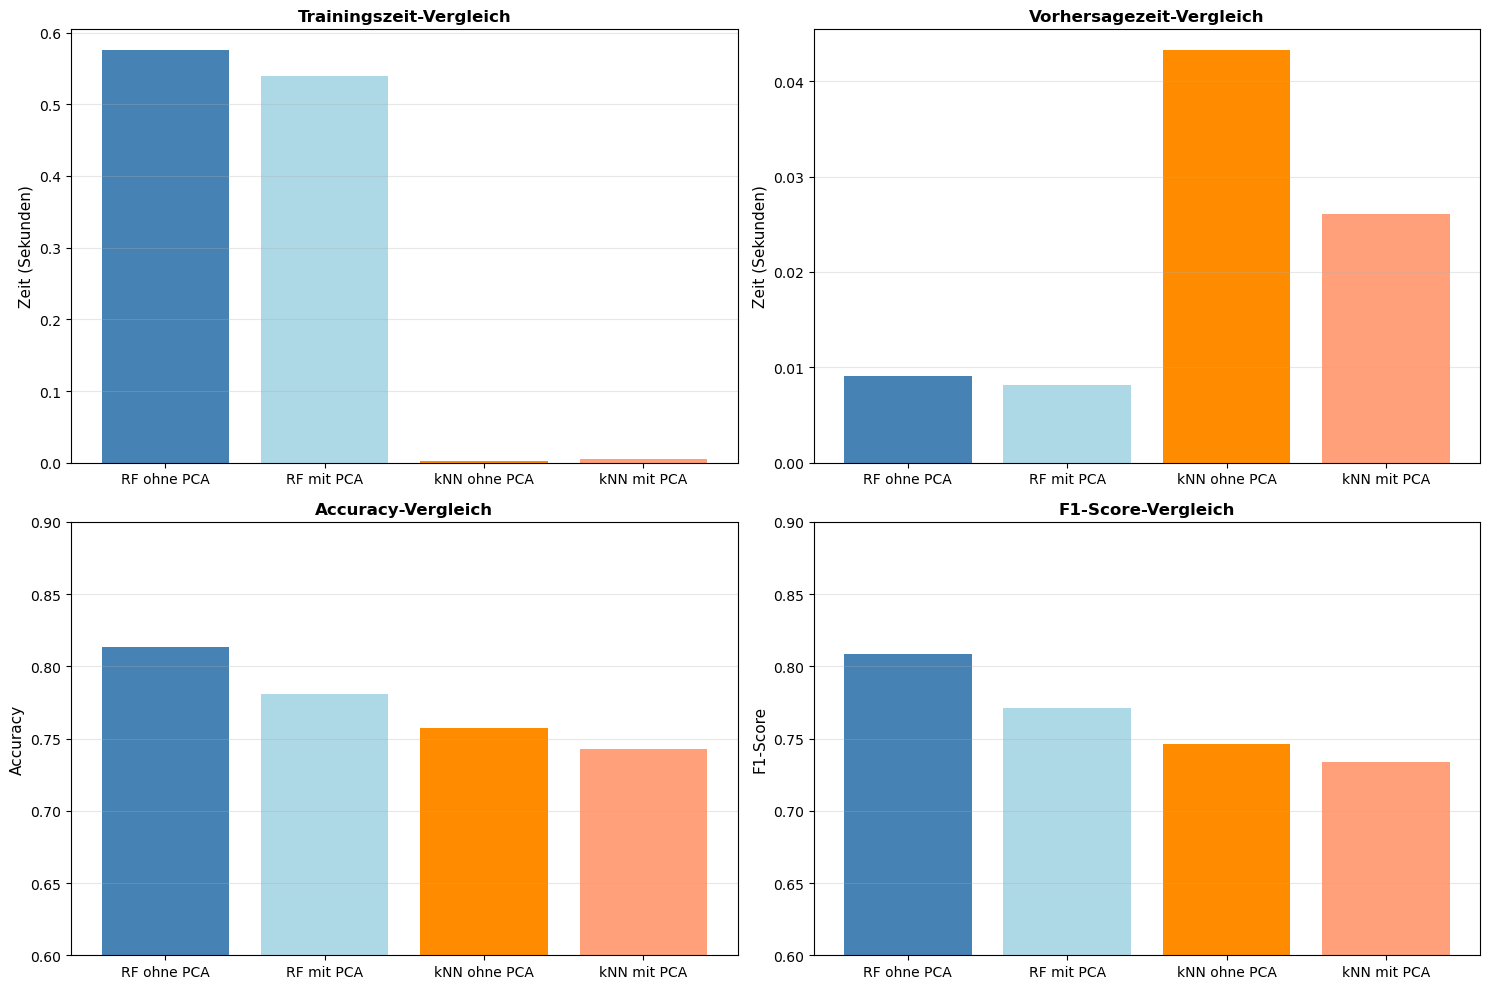

In [11]:
# Zusammenfassende Tabelle erstellen
results_data = {
    'Modell': ['Random Forest', 'Random Forest + PCA', 'kNN', 'kNN + PCA'],
    'Trainingszeit (s)': [train_time_no_pca, train_time_pca, train_time_knn_no_pca, train_time_knn_pca],
    'Vorhersagezeit (s)': [pred_time_no_pca, pred_time_pca, pred_time_knn_no_pca, pred_time_knn_pca],
    'Accuracy': [acc_no_pca, acc_pca, acc_knn_no_pca, acc_knn_pca],
    'Precision': [prec_no_pca, prec_pca, prec_knn_no_pca, prec_knn_pca],
    'Recall': [rec_no_pca, rec_pca, rec_knn_no_pca, rec_knn_pca],
    'F1-Score': [f1_no_pca, f1_pca, f1_knn_no_pca, f1_knn_pca]
}

results_df = pd.DataFrame(results_data)
print("="*100)
print("ZUSAMMENFASSENDE ERGEBNISTABELLE")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Visualisierung der Vergleiche
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Trainingszeit-Vergleich
axes[0, 0].bar(['RF ohne PCA', 'RF mit PCA', 'kNN ohne PCA', 'kNN mit PCA'],
               [train_time_no_pca, train_time_pca, train_time_knn_no_pca, train_time_knn_pca],
               color=['steelblue', 'lightblue', 'darkorange', 'lightsalmon'])
axes[0, 0].set_ylabel('Zeit (Sekunden)', fontsize=11)
axes[0, 0].set_title('Trainingszeit-Vergleich', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Vorhersagezeit-Vergleich
axes[0, 1].bar(['RF ohne PCA', 'RF mit PCA', 'kNN ohne PCA', 'kNN mit PCA'],
               [pred_time_no_pca, pred_time_pca, pred_time_knn_no_pca, pred_time_knn_pca],
               color=['steelblue', 'lightblue', 'darkorange', 'lightsalmon'])
axes[0, 1].set_ylabel('Zeit (Sekunden)', fontsize=11)
axes[0, 1].set_title('Vorhersagezeit-Vergleich', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Accuracy-Vergleich
axes[1, 0].bar(['RF ohne PCA', 'RF mit PCA', 'kNN ohne PCA', 'kNN mit PCA'],
               [acc_no_pca, acc_pca, acc_knn_no_pca, acc_knn_pca],
               color=['steelblue', 'lightblue', 'darkorange', 'lightsalmon'])
axes[1, 0].set_ylabel('Accuracy', fontsize=11)
axes[1, 0].set_title('Accuracy-Vergleich', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim([0.6, 0.9])
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. F1-Score-Vergleich
axes[1, 1].bar(['RF ohne PCA', 'RF mit PCA', 'kNN ohne PCA', 'kNN mit PCA'],
               [f1_no_pca, f1_pca, f1_knn_no_pca, f1_knn_pca],
               color=['steelblue', 'lightblue', 'darkorange', 'lightsalmon'])
axes[1, 1].set_ylabel('F1-Score', fontsize=11)
axes[1, 1].set_title('F1-Score-Vergleich', fontsize=12, fontweight='bold')
axes[1, 1].set_ylim([0.6, 0.9])
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 3.5 Diskussion der Ergebnisse


#### 1. Trainingszeit-Vergleich:
- RF: RF ohne PCA deutlich höher als RF mit PCA.
- kNN: Beide Balken sehr niedrig und fast gleich.

RF muss mit PCA weniger Features berechnen, dass bedeutet es ist schneller. kNN speichert nur Daten, deshalb kaum Unterschied.

#### 2. Vorhersagezeit-Vergleich:
- KNN ohne PCA viel höher als kNN mit PCA.

KNN berechnet die Distanzen zu allen Punkten in allen Dimensionen. Durch die wenigen Dimensionen ist es schneller.

#### 3. Accuracy-Vergleich:
- Minimale Unterschiede zwischen mit/ohne PCA.

PCA mit 95% Varianz behält wichtige Informationen. RF ist robust durch Ensemble. kNN profitiert vom Wegfall irrelevanter Dimensionen.

#### 4. F1-Score-Vergleich (untere rechte Grafik):
**Was man sieht:**
- Ähnliches Muster wie Accuracy
- Minimale Unterschiede zwischen mit/ohne PCA

**Warum:** F1-Score kombiniert Precision/Recall → gleiche Stabilität wie Accuracy.

### Fazit:
**kNN** profitiert am meisten von PCA (extremer Geschwindigkeitsgewinn bei Vorhersage, stabile Qualität). **RF** erhält Geschwindigkeitsvorteile bei minimalem Qualitätsverlust. PCA mit 95% Varianz ist optimal.